# Libraries

In [1]:
import numpy as np
np.set_printoptions(suppress=True)

import pandas as pd

import scipy
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

from scipy import optimize

# Methods

In [2]:
def auc(y, y_hat):
    n1 = np.sum(y == 1)
    n2 = np.sum(y == 0)
    
    R1 = np.sum(stats.rankdata(y_hat.values)[y.values == 1])
    
    U = R1 - (n1*(n1+1))/2
    
    return(U/(n1*n2))

In [3]:
def disparate_impact(y_hat, s):
    priv = np.mean(y_hat.values[s.values == 0])/np.mean(y_hat.values[s.values == 1])
    disc = np.mean(y_hat.values[s.values == 1])/np.mean(y_hat.values[s.values == 0])
    
    return np.min([priv, disc])

In [4]:
def equality_of_opportunity(y_hat, y, s, out = 1):
    eoo = np.mean(y_hat.values[(s.values == 1) & (y.values == out)]) / np.mean(y_hat.values[(s.values == 0) & (y.values == out)])
    
    return(eoo)

In [5]:
def sigmoid(w, X):
    return(1/(1 + np.exp(-np.sum(w*X, axis=1))))

In [6]:
def logistic_loss(w, X, y):
    y_hat = sigmoid(w, X).values
    
    # NUMERICAL UNDERFLOW AND OVERFLOW
    y_hat[y_hat == 0] = 0.00001
    y_hat[y_hat == 1] = 0.99999
    
    return -np.mean(y.values * np.log2(y_hat) + (1 - y.values) * np.log2(1 - y_hat))

In [7]:
def performance_score(w, X, y, s):
    X_d = X.loc[s == 1, :]
    X_p = X.loc[s == 0, :]
    
    y_d = y[s == 1]
    y_p = y[s == 0]
    
    y_hat = sigmoid(w, X)
    y_d_hat = sigmoid(w, X_d)
    y_p_hat = sigmoid(w, X_p)
    
    print(f'AUC: {auc(y, y_hat)}, AUC Disc: {auc(y_d, y_d_hat)}, AUC Priv: {auc(y_p, y_p_hat)}')
    print(f'LL: {logistic_loss(w, X, y)}, LL Disc: {logistic_loss(w, X_d, y_d)}, LL Priv: {logistic_loss(w, X_p, y_p)}')
    print(f'Disparate impact {disparate_impact(y_hat, s)}')

# Kalai Smorodinsky Solution

In [8]:
def FairLogisticRegression(w, X, y, s, l):
    y_hat = sigmoid(w, X).values
    
    # NUMERICAL UNDERFLOW AND OVERFLOW
    y_hat[y_hat == 0] = 0.00001
    y_hat[y_hat == 1] = 0.99999
    
    y_d_hat = y_hat[s == 0]
    y_p_hat = y_hat[s == 1]
    
    log_loss = -np.mean(y.values * np.log2(y_hat) + (1 - y.values) * np.log2(1 - y_hat))
    stat_parity = np.power(np.mean(y_p_hat) - np.mean(y_d_hat), 2)
    
    return l * log_loss + (1 - l) * stat_parity

def calculate_l(log_loss, disp_impact, prior_l = 1):
    max_ll = np.max(1/np.array(log_loss))
    max_di = np.max(disp_impact)

    di_0 = disp_impact[0]
    di_1 = disp_impact[-1]

    ll_0 = (1/np.array(log_loss))[0]
    ll_1 = (1/np.array(log_loss))[-1]

    l = (max_ll * di_0 - max_di * ll_0) /(max_di * ll_1 - max_di * ll_0 - max_ll * di_1 + max_ll * di_0)
    return prior_l * l

def perform_exp(X, y, s, lower_bound, upper_bound):  
    log_loss = []
    disp_impact = []
    
    w = np.repeat(0.0, X.shape[1])
    model = optimize.minimize(fun=FairLogisticRegression, x0=w, args=(X, y, s, lower_bound), method='SLSQP')
    
    log_loss.append(logistic_loss(model.x, X, y))
    disp_impact.append(disparate_impact(sigmoid(model.x, X), s))
    
    w = np.repeat(0.0, X.shape[1])
    model = optimize.minimize(fun=FairLogisticRegression, x0=w, args=(X, y, s, upper_bound), method='SLSQP')
    
    log_loss.append(logistic_loss(model.x, X, y))
    disp_impact.append(disparate_impact(sigmoid(model.x, X), s))
    
    return log_loss, disp_impact

def loop_exp(X, y, s, no_iter = 5):
    lower_bound = 0
    upper_bound = 1
    
    log_loss, disp_impact = perform_exp(X, y, s, lower_bound, upper_bound)
    prior_l = 1
    print('And we begin...')
    
    for i in range(no_iter):
        new_l = calculate_l(log_loss, disp_impact, prior_l)
        prior_l = new_l
        print(new_l)
        
        w = np.repeat(0.0, X.shape[1])
        model = optimize.minimize(fun=FairLogisticRegression, x0=w, args=(X, y, s, new_l), method='SLSQP')

        ll = logistic_loss(model.x, X, y)
        di = disparate_impact(sigmoid(model.x, X), s)

        ll_gain = log_loss[0] - logistic_loss(model.x, X, y) + log_loss[-1] - logistic_loss(model.x, X, y)
        di_gain = disp_impact[0] - disparate_impact(sigmoid(model.x, X), s) + disp_impact[-1] - disparate_impact(sigmoid(model.x, X), s)

        performance_score(model.x, X, y, s)
        
        if ((ll_gain > 0) & (di_gain > 0)):
            lower_bound = new_l
            log_loss[0] = logistic_loss(model.x, X, y)
            disp_impact[0] = disparate_impact(sigmoid(model.x, X), s)
        elif ((ll_gain < 0) & (di_gain < 0)):
            upper_bound = new_l
            log_loss[1] = logistic_loss(model.x, X, y)
            disp_impact[1] = disparate_impact(sigmoid(model.x, X), s)
        else:
            break
    
    return model

# Experiment

In [9]:
data = pd.read_csv('Data/adult_prepared.csv')

In [10]:
y = data['Income']
s = data['Sex']

X = data.drop(['Income', 'Sex'], axis=1)
X = (X - np.mean(X))/np.std(X)

In [11]:
model = loop_exp(X, y, s)

And we begin...
0.4577647037973759
AUC: 0.8770183019593714, AUC Disc: 0.9018997135724498, AUC Priv: 0.8564772492384013
LL: 0.6229854488200653, LL Disc: 0.48650903128650524, LL Priv: 0.6904470134485178
Disparate impact 0.6439440794280061
0.04485036439276766
AUC: 0.8196002549044129, AUC Disc: 0.8459950545443227, AUC Priv: 0.8283959070132805
LL: 0.6881519345302163, LL Disc: 0.6499634627666226, LL Priv: 0.7070288518944049
Disparate impact 0.9416416672627148
0.03451257498041285
AUC: 0.8155832352058654, AUC Disc: 0.8422101822199868, AUC Priv: 0.8261106445850012
LL: 0.6924058229085147, LL Disc: 0.6582583882302387, LL Priv: 0.7092852179943204
Disparate impact 0.9556905031212773
0.026398753484230732
AUC: 0.8127508905764199, AUC Disc: 0.8428545380975523, AUC Priv: 0.8231319995122974
LL: 0.6963841273027316, LL Disc: 0.6670965885467173, LL Priv: 0.7108612305584008
Disparate impact 0.9655381712406562
0.020053034184331943
AUC: 0.8101938703660825, AUC Disc: 0.8405058710927469, AUC Priv: 0.82149357405

# Plot Results

In [12]:
log_loss = []
disp_impact = []
for l in np.linspace(0, 1, 21):
    print(l)
    w = np.repeat(0.0, X.shape[1])
    model = optimize.minimize(fun=FairLogisticRegression, x0=w, args=(X, y, s, l), method='SLSQP')
    
    log_loss.append(logistic_loss(model.x, X, y))
    disp_impact.append(disparate_impact(sigmoid(model.x, X), s))

0.0
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001
1.0


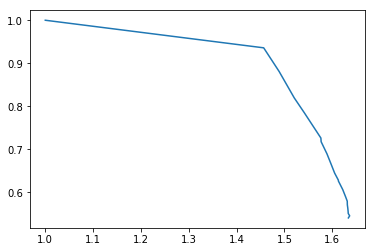

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(1/np.array(log_loss), disp_impact)